---
title: "Solvers"
format:
  html:
    embed-resources: true
    code-fold: true
    toc: true
---

## Notes

From the root directory, run "pip install -e ." in your current environment to download the package with the environment in order to wrap around gym and rllib. The information of the download is in setup.py.

## Versions and Dependencies

In [16]:
import ray
print(ray.__version__)

2.39.0


In [17]:
import subprocess

# Run the pip list command and print the output
installed_packages = subprocess.run(["pip", "list"], capture_output=True, text=True)
print(installed_packages.stdout)

Package                   Version     Editable project location
------------------------- ----------- ---------------------------------
absl-py                   2.1.0
aiosignal                 1.3.2
appnope                   0.1.4
asttokens                 3.0.0
attrs                     25.1.0
certifi                   2025.1.31
charset-normalizer        3.4.1
click                     8.1.8
cloudpickle               3.1.1
cmake                     3.31.4
comm                      0.2.2
contourpy                 1.3.1
cycler                    0.12.1
debugpy                   1.8.12
decorator                 5.1.1
dm-tree                   0.1.9
exceptiongroup            1.2.2
executing                 2.1.0
Farama-Notifications      0.0.4
filelock                  3.17.0
fonttools                 4.56.0
frozenlist                1.5.0
fsspec                    2025.2.0
geosearch_package         0.1.0
gymnasium                 1.0.0
idna                      3.10
importlib_metadata  

## Libraries

In [18]:
from ray.rllib.algorithms.sac import SACConfig

In [19]:
from gymnasium.envs.registration import register
import gymnasium as gym
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
#from ray.rllib.algorithms.ppo import PPOConfig
#from ray.rllib.algorithms.sac import SACConfig
#from ray.rllib.algorithms.dqn import DQNConfig
import numpy as np
from ray import tune
#from ray.rllib.algorithms.appo import APPOConfig
import matplotlib
import matplotlib.pyplot as plt
import torch
import pygame
#from ray.rllib.models.torch.torch_action_dist import TorchCategorical
import os

In [20]:
# set up matplotlib interactive mode
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

In [21]:
from lunabot.geosearch import GeosearchEnv, Utils

## Load Environment

In [22]:
register(
    id="GeosearchEnv-v0",
    entry_point="geosearch_package.geosearch:GeosearchEnv",
)
env = GeosearchEnv()
#env = gym.make("GeosearchEnv-v0")
obs, info = env.reset()
print("Observation:", obs)

Observation: {'height': array([11.882885], dtype=float32), 'battery': array([73250.], dtype=float32), 'position': array([18., 17.], dtype=float32), 'sunlight': array([0.], dtype=float32), 'dust': array([0.22945473], dtype=float32), 'water_prob': array([0.], dtype=float32), 'gold_prob': array([0.], dtype=float32)}


/Users/jbm/miniforge3/envs/rover/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment GeosearchEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


## Helper functions to visualize training

In [23]:
def plot_metrics(rewards, lengths):
    fig = plt.figure(1, figsize=(16, 8))
    plt.clf()

    # plt.subplots(ncols=2, figsize=(12,6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.set_title('Mean Rewards')
    ax1.set_xlabel('Evaluation Interval')
    ax1.set_ylabel('Mean Reward')
    ax1.plot(rewards)

    ax2.set_title('Mean Episode Length')
    ax2.set_xlabel('Evaluation Interval')
    ax2.set_ylabel('Episode Length')
    ax2.plot(lengths)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [24]:
# Define a generic policy wrapper class that works with all RLlib algorithms
class RLlibPolicyWrapper:
    def __init__(self, algo):
        self.algo = algo
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
    def process_state(self, state):
        # Convert dictionary observation to array
        state_array = np.concatenate([
            state['height'],
            state['battery'],
            state['position'],
            state['sunlight'],
            state['dust'],
            state['water_prob'],
            state['gold_prob']
        ])
        return state_array
        
    def get_action(self, state):
        # Get action from policy
        action = self.algo.compute_single_action(
            observation=state,
            explore=False  # Don't use exploration during visualization
        )
        return action

def visualize_policy(env, algo, algo_name="Algorithm", episodes=5, max_steps=50, save_gif=True, gif_dir="policy_gifs"):
    """
    Generic function to visualize any RLlib algorithm's policy.
    
    Args:
        env: The environment instance
        algo: The RLlib algorithm instance (PPO, SAC, DQN, or APPO)
        algo_name: Name of the algorithm for the output filename
        episodes: Number of episodes to run
        max_steps: Maximum steps per episode
        save_gif: Whether to save the visualization as a GIF
        gif_dir: Directory to save the GIFs (default: "policy_gifs")
    """
    try:
        # Initialize Pygame first
        pygame.init()
        
        # Create policy wrapper
        policy_wrapper = RLlibPolicyWrapper(algo)
        
        # Initialize visualization
        if env.render_mode != 'human':
            env.render_mode = 'human'
        env._init_render()
        
        frames = []
        total_reward = 0
        
        # Create directory for GIFs if it doesn't exist
        if save_gif:
            os.makedirs(gif_dir, exist_ok=True)
            gif_path = os.path.join(gif_dir, f"{algo_name.lower()}_policy.gif")
            print(f"GIF will be saved to: {gif_path}")
        
        for episode in range(episodes):
            state, info = env.reset()
            episode_reward = 0
            terminated = False
            steps = 0
            
            while not terminated and steps < max_steps:
                # Handle Pygame events
                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        raise KeyboardInterrupt
                
                # Render current state
                env.render()
                if save_gif:
                    frame = pygame.surfarray.array3d(env.screen)
                    frames.append(np.transpose(frame, (1, 0, 2)))
                
                # Get action from policy
                action = policy_wrapper.get_action(state)
                
                # Take action in environment
                next_state, reward, terminated, truncated, _ = env.step(action)
                
                episode_reward += reward
                state = next_state
                steps += 1
                
                # Add small delay for visualization
                pygame.time.wait(66)  # ~15 FPS
                
            total_reward += episode_reward
            print(f"Episode {episode + 1} finished with reward: {episode_reward:.2f}")
        
        if save_gif and frames:
            Utils.create_gif(frames, filename=gif_path, duration=66)
            print(f"GIF saved successfully to {gif_path}")
        
        avg_reward = total_reward / episodes
        print(f"Average reward over {episodes} episodes: {avg_reward:.2f}")

    except KeyboardInterrupt:
        print("\nVisualization interrupted by user")
    
    except Exception as e:
        print(f"An error occurred during visualization: {str(e)}")
    
    finally:
        # Ensure proper cleanup
        if hasattr(env, 'close'):
            env.close()
        
        # Additional Pygame cleanup
        pygame.quit()
        print("Visualization completed and resources cleaned up")

## SAC

### Ray Instance

In [ ]:
config = SACConfig()
config.framework_str = "torch"
config.env = GeosearchEnv
config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)

# Computational resources
config.num_workers = 8
config.evaluation_num_workers = 4
config.evaluation_interval = 10 # changed from 100 to 10 not in this run though -- maybe linke it to the battery completioni used to calculate things?

config.training(
    replay_buffer_config={
        "type": "MultiAgentReplayBuffer",
        "capacity": 100000,
    }
)


# Model and rollout configuration
config.model = {
    "fcnet_hiddens": [256, 256, 128],
    "fcnet_activation": "relu",
    "max_seq_len": 20  # Add missing parameter # change?
}

# Training parameters
config.rollout_fragment_length = 1
config.train_batch_size = 256
config.target_network_update_freq = 1
config.lr = 3e-4

algo = config.build()

2025-02-09 22:16:46,156	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation_num_workers` has been deprecated. Use `AlgorithmConfig.evaluation_num_env_runners` instead. This will raise an error in the future!
/Users/jbm/miniforge3/envs/rover/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:567: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/jbm/miniforge3/envs/rover/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interfa

### Training

In [26]:
rewards = []
lengths = []

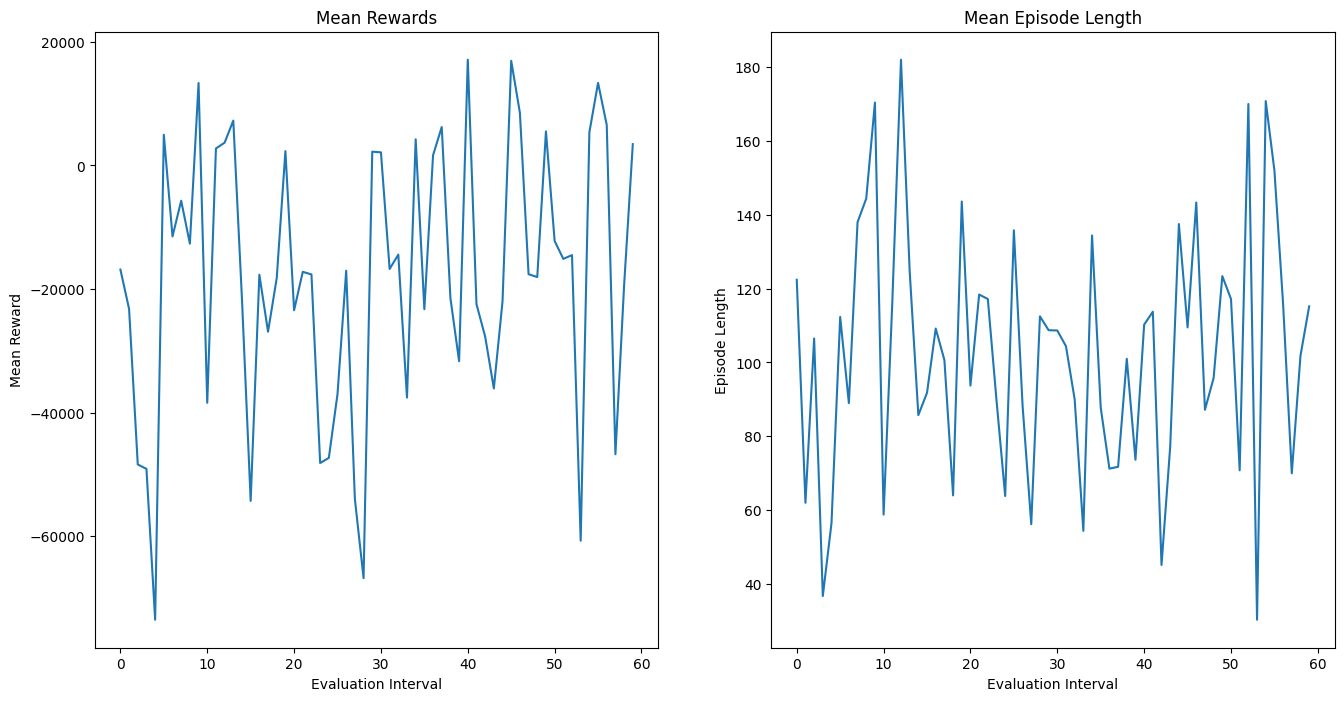

In [27]:
import time

TRAINING_ITERATIONS = 6000
EVAL_INTERVAL = 100


# Modified training loop with better tracking
best_reward = float('-inf')
start_time = time.time()

for i in range(TRAINING_ITERATIONS):
    result = algo.train()
    
    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        current_reward = evaluation_results['env_runners']['episode_return_mean']
        rewards.append(current_reward)
        lengths.append(evaluation_results['env_runners']['episode_len_mean'])
        
        # Save best model
        if current_reward > best_reward:
            best_reward = current_reward
            checkpoint_dir = f"checkpoints/sac_lunar_best"
            algo.save(checkpoint_dir)
            
        # Print progress
        elapsed_time = (time.time() - start_time) / 3600  # in hours
        print(f"\nIteration {i+1}/{TRAINING_ITERATIONS}")
        print(f"Time elapsed: {elapsed_time:.2f} hours")
        print(f"Current reward: {current_reward:.2f}")
        print(f"Best reward so far: {best_reward:.2f}")
        
        plot_metrics(rewards, lengths)

### Save the weights:

In [14]:
#policy = algo.get_policy()
weights = algo.get_weights()

### Visualize how the algorithm performs:

In [28]:
# For SAC
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="SAC", episodes=3, max_steps=500)

GIF will be saved to: policy_gifs/sac_policy.gif
Episode 1 finished with reward: -99175.00
Episode 2 finished with reward: 937.00
Episode 3 finished with reward: 4836.00
Gameplay GIF saved as policy_gifs/sac_policy.gif
GIF saved successfully to policy_gifs/sac_policy.gif
Average reward over 3 episodes: -31134.00
Visualization completed and resources cleaned up


**Notes:** Battery still low, takes too much to move but specially gather. 
If Battery is done we should make it a terminal state?
Look at clifs (shouold be smooth on one side some how)

## PPO

### Ray Instance

In [ ]:
#from ray.rllib.algorithms.ppo import PPOConfig
config = PPOConfig()
config.framework_str = "torch"
config.env = GeosearchEnv
config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)
config.num_workers = 4
config.evaluation_interval = 50
config.evaluation_num_workers = 2

algo = config.build()


2024-12-08 15:51:52,779	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation_num_workers` has been deprecated. Use `AlgorithmConfig.evaluation_num_env_runners` instead. This will raise an error in the future!
/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:567: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json

### Training

In [ ]:
rewards = []
lengths = []

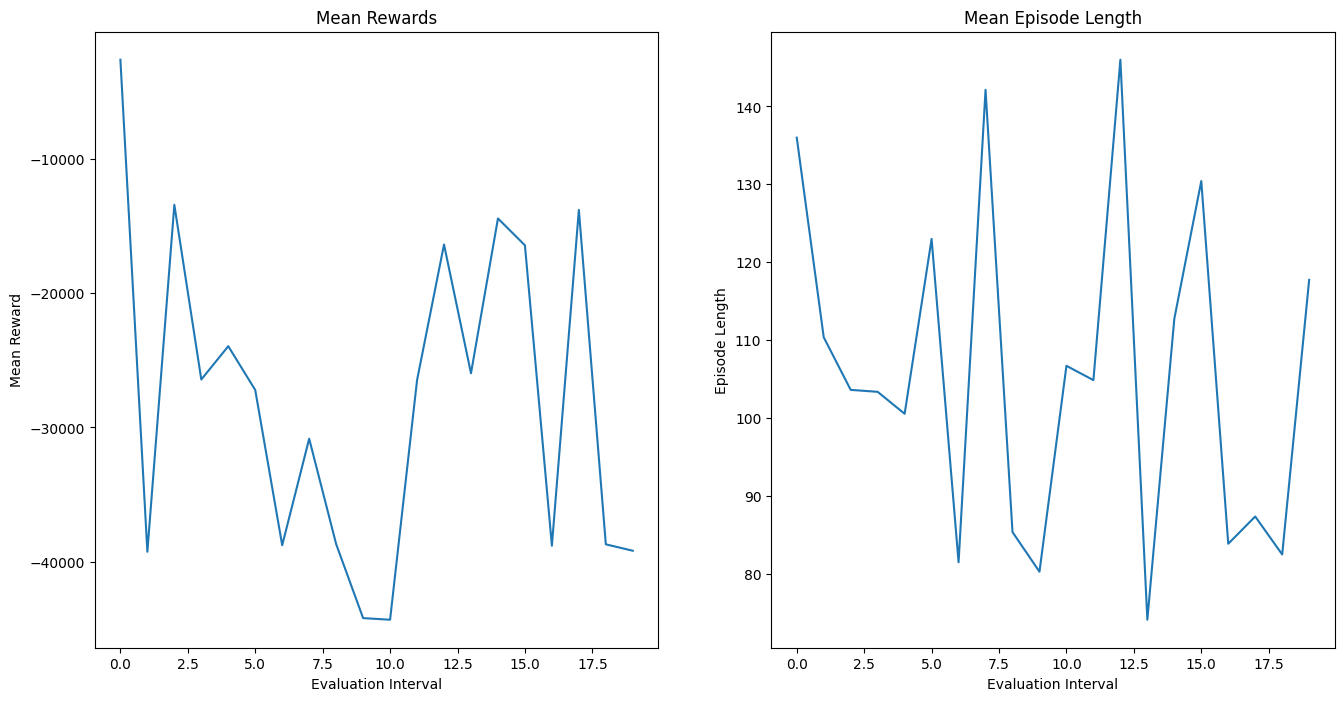

In [ ]:
TRAINING_ITERATIONS = 1000
EVAL_INTERVAL = 50


for i in range(TRAINING_ITERATIONS):
    
    algo.train()

    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        rewards.append(evaluation_results['env_runners']['episode_return_mean'])
        lengths.append(evaluation_results['env_runners']['episode_len_mean'])
        plot_metrics(rewards, lengths)

### Saving the weights:

In [ ]:
#policy = algo.get_policy()
weights = algo.get_weights()

### Visualize how the algorithm performs:

In [ ]:
# For PPO
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="PPO", episodes=3, max_steps=100)

GIF will be saved to: policy_gifs/ppo_policy.gif


2024-12-08 17:01:39.767 python[31705:1541050] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-08 17:01:39.767 python[31705:1541050] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Episode 1 finished with reward: -1105.00
Episode 2 finished with reward: -100669.00
Episode 3 finished with reward: -101930.00
Gameplay GIF saved as policy_gifs/ppo_policy.gif
GIF saved successfully to policy_gifs/ppo_policy.gif
Average reward over 3 episodes: -67901.33
Visualization completed and resources cleaned up


## DQN/Rainbow

### Ray Instance

In [19]:
config = DQNConfig()
config.framework_str = "torch"
config.env = GeosearchEnv
config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)
config.num_workers = 4
config.evaluation_interval = 50
config.evaluation_num_workers = 2
config.training(
    replay_buffer_config={
        "type": "MultiAgentReplayBuffer",
        "capacity": 10000,  # Adjust as needed
        # If you want prioritized replay:
        # "type": "MultiAgentPrioritizedReplayBuffer",
        # "prioritized_replay_alpha": 0.6,
        # "prioritized_replay_beta": 0.4,
        # "prioritized_replay_eps": 1e-6,
    }
)

algo = config.build()

2024-12-08 18:08:44,803	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation_num_workers` has been deprecated. Use `AlgorithmConfig.evaluation_num_env_runners` instead. This will raise an error in the future!
2024-12-08 18:08:47,447	WARNING util.py:61 -- Install gputil for GPU system monitoring.


### Training

In [20]:
rewards = []
lengths = []

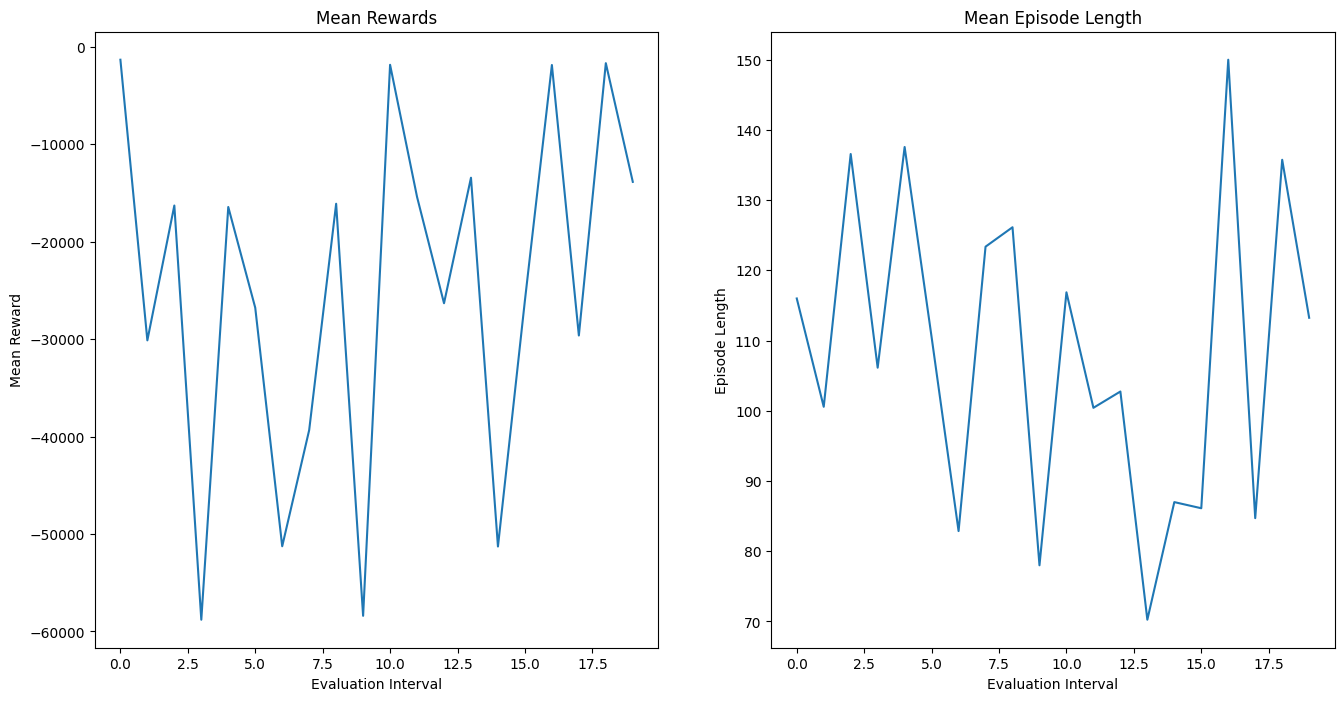

In [21]:
TRAINING_ITERATIONS = 1000
EVAL_INTERVAL = 50

for i in range(TRAINING_ITERATIONS):
    
    algo.train()

    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        rewards.append(evaluation_results['env_runners']['episode_return_mean'])
        lengths.append(evaluation_results['env_runners']['episode_len_mean'])
        plot_metrics(rewards, lengths)
     

### Save the weights:

In [22]:
#policy = algo.get_policy()
weights = algo.get_weights()

### Visualize how the algorithm performs:

In [23]:
# For DQN
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="DQN", episodes=3, max_steps=100)

GIF will be saved to: policy_gifs/dqn_policy.gif
Episode 1 finished with reward: -1230.00
Episode 2 finished with reward: -1265.00
Episode 3 finished with reward: -870.00
Gameplay GIF saved as policy_gifs/dqn_policy.gif
GIF saved successfully to policy_gifs/dqn_policy.gif
Average reward over 3 episodes: -1121.67
Visualization completed and resources cleaned up


## APPO

### Ray Instance and wrapping environment

In [24]:
# Initialize Ray
ray.init(ignore_reinit_error=True)

# Define the custom observation wrapper
class NoLimitObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        if isinstance(env.observation_space, gym.spaces.Dict):
            new_spaces = {}
            for key, space in env.observation_space.spaces.items():
                if isinstance(space, gym.spaces.Box):
                    shape = space.shape
                    new_spaces[key] = gym.spaces.Box(
                        low=-np.inf, high=np.inf, shape=shape, dtype=np.float32
                    )
                else:
                    # If there are other space types, handle them as needed
                    new_spaces[key] = space
            self.observation_space = gym.spaces.Dict(new_spaces)
        else:
            # If it's a single Box space
            shape = env.observation_space.shape
            self.observation_space = gym.spaces.Box(
                low=-np.inf, high=np.inf, shape=shape, dtype=np.float32
            )
    
    def observation(self, observation):
        return observation


# Define the environment creator function
def env_creator(env_config):
    env = GeosearchEnv()  # Directly instantiate the environment class
    env = NoLimitObservationWrapper(env)
    return env

# Register the custom environment
tune.register_env("NoLimitGeosearchEnv", env_creator)

# Configure APPO with the custom environment
config = APPOConfig()
config = config.environment(env="NoLimitGeosearchEnv", disable_env_checking=True)
config = config.framework("torch")
config = config.rollouts(num_env_runners=4)
config = config.evaluation(evaluation_num_workers=2, evaluation_interval=50)

# Build the algorithm
algo = config.build()


2024-12-08 20:29:55,293	INFO worker.py:1652 -- Calling ray.init() again after it has already been called.
2024-12-08 20:29:55,296	WARNING deprecation.py:50 -- DeprecationWarning: `rollouts` has been deprecated. Use `AlgorithmConfig.env_runners(..)` instead. This will raise an error in the future!
2024-12-08 20:29:55,296	WARNING deprecation.py:50 -- DeprecationWarning: `AlgorithmConfig.evaluation(evaluation_num_workers=..)` has been deprecated. Use `AlgorithmConfig.evaluation(evaluation_num_env_runners=..)` instead. This will raise an error in the future!
2024-12-08 20:30:00,435	WARNING util.py:61 -- Install gputil for GPU system monitoring.


### Training

In [25]:
rewards = []
lengths = []

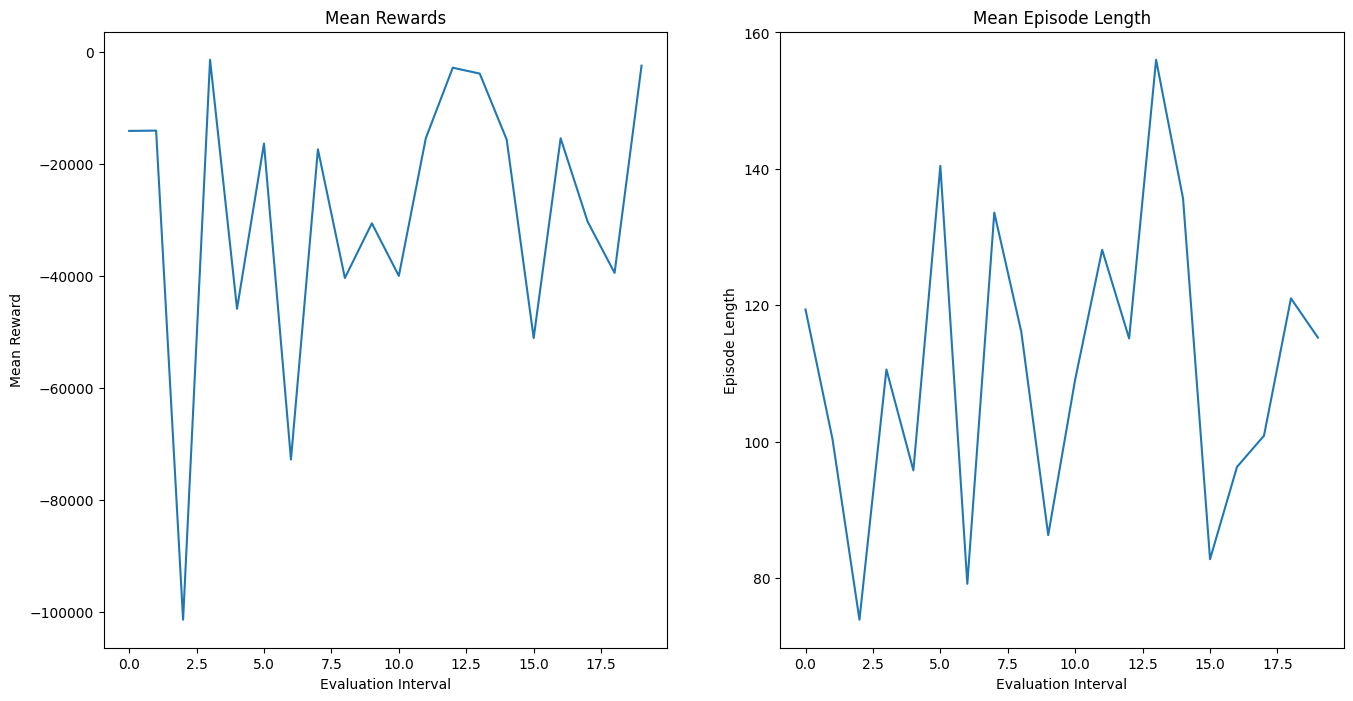

In [26]:
TRAINING_ITERATIONS = 1000
EVAL_INTERVAL = 50


for i in range(TRAINING_ITERATIONS):
    result = algo.train()
    
    # Access the mean episode reward and length from 'env_runners'
    mean_reward = result['env_runners']['episode_reward_mean']
    mean_length = result['env_runners']['episode_len_mean']
    
    print(f"Iteration {i+1}: episode_reward_mean = {mean_reward}, episode_len_mean = {mean_length}")

    if (i+1) % EVAL_INTERVAL == 0:
        evaluation_results = algo.evaluate()
        eval_mean_reward = evaluation_results['env_runners']['episode_reward_mean']
        eval_mean_length = evaluation_results['env_runners']['episode_len_mean']
        rewards.append(eval_mean_reward)
        lengths.append(eval_mean_length)
        plot_metrics(rewards, lengths)

### Save the weights:

In [27]:
# For APPO
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, algo_name="APPO", episodes=3, max_steps=100)

GIF will be saved to: policy_gifs/appo_policy.gif
Episode 1 finished with reward: -2250.00
Episode 2 finished with reward: -1676.00
Episode 3 finished with reward: -1920.00
Gameplay GIF saved as policy_gifs/appo_policy.gif
GIF saved successfully to policy_gifs/appo_policy.gif
Average reward over 3 episodes: -1948.67
Visualization completed and resources cleaned up


### Visualize how the algorithm performs:

In [ ]:
env = GeosearchEnv(render_mode='human')
visualize_policy(env, algo, episodes=3, max_steps=100)

GIF will be saved to: policy_gifs/algorithm_policy.gif
Episode 1 finished with reward: -2130.00
Episode 2 finished with reward: -2100.00


Exception in thread Thread-14:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 76, in run
    self.step()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 149, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 51, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/fml/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty


Episode 3 finished with reward: -2820.00
Gameplay GIF saved as policy_gifs/algorithm_policy.gif
GIF saved successfully to policy_gifs/algorithm_policy.gif
Average reward over 3 episodes: -2350.00
Visualization completed and resources cleaned up


: 